In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Imports

In [7]:
# file imports
file_path_forecasts = '../data/raw/ibes-forecasts.parquet'

# IBES forecasts
df_forecasts = pd.read_parquet(file_path_forecasts)
df_forecasts.head()

,TICKER,CUSIP,OFTIC,CNAME,ESTIMATOR,ANALYS,FPI,MEASURE,VALUE,FPEDATS,REVDATS,ANNDATS,ACTUAL,ANNDATS_ACT
0,0000,87482X10,TLMR,TALMER BANCORP,149,119962,1,EPS,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30
1,0000,87482X10,TLMR,TALMER BANCORP,228,80474,1,EPS,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
2,0000,87482X10,TLMR,TALMER BANCORP,952,50789,1,EPS,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
3,0000,87482X10,TLMR,TALMER BANCORP,873,79092,1,EPS,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
4,0000,87482X10,TLMR,TALMER BANCORP,1267,71182,1,EPS,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30


# Preprocessing
df_forecasts:
- Lower case all columns in df_forecasts
- Drop unncessary columns
- Include only forecasts issued no earlier than 1 year ahead and no later than 30 days before fiscal year end
- Rename columns
- Delete rows with actual_eps = NAN or estimated_eps = NAN
- Exclude forecasts for companies which only one analyst provides a forecast
- Exclude all analysts appearing in the initial 2-3 years of the dataset (migitating problem of experience)
- (Retain the last forecast an analyst issues in a particular year)
- ...

In [8]:
# lower case
df_forecasts = df_forecasts.rename(columns={col: col.lower() for col in df_forecasts.columns})

# Drop unncessary columns
columns_to_drop = ["fpi","measure","cusip"]
df_forecasts = df_forecasts.drop(columns=columns_to_drop)

In [10]:
# convert columns with dates to datetime
def convert_to_datetime(df):
    columns_to_convert = ['fpedats','revdats', "anndats", 'anndats_act']
    for column in columns_to_convert:
        df[column] = pd.to_datetime(df[column])
    return df
df_forecasts = convert_to_datetime(df_forecasts)

# filter forecasts  based on time
df_forecasts['forecast_horizon'] = df_forecasts['fpedats'] - df_forecasts['anndats']
df_forecasts = df_forecasts[(df_forecasts['forecast_horizon']> pd.Timedelta(days=30))&(df_forecasts['forecast_horizon']<pd.Timedelta(days=365))]

# calculate the mean forecast horizon of analyst i's forecasts for company j in fiscal period t and append to df
df_forecasts['mean_forecast_horizon_days'] = df_forecasts.groupby(['analys','ticker','fpedats'])['forecast_horizon'].transform('mean')
df_forecasts['mean_forecast_horizon_days'] = df_forecasts['mean_forecast_horizon_days'].dt.days
df_forecasts.head()

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,forecast_horizon,mean_forecast_horizon_days
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182


In [9]:
# test
analyst_id = 113333
subset_analyst_i = df_forecasts[(df_forecasts['ticker'] == "AAPL") & (df_forecasts['fpedats'].dt.year == 2020) & (df_forecasts['analys'] == analyst_id)]
subset_analyst_i

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,forecast_horizon,mean_forecast_horizon_days
128641,AAPL,AAPL,APPLE,171,113333,3.2565,2020-09-30,2020-01-22,2019-10-30,3.28,2020-10-29,336 days,291
128696,AAPL,AAPL,APPLE,171,113333,3.3510,2020-09-30,2020-01-28,2020-01-28,3.28,2020-10-29,246 days,291


rename columns to natural language

In [10]:
# rename columns
df_forecasts = df_forecasts.rename(columns={"ticker": "ibes_ticker_pk", "oftic": "official_ticker", "cname": "company_name",
                                            "analys": "analyst", "value": "estimated_eps", "fpedats": "fiscal_period_ending", 
                                            "revdats": "revision_date", "anndats": "announce_date", "actual": "actual_eps", "anndats_act": "announce_date_actual",
                                            "difference_date": "forecast_horizon"})

In [11]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182


remove empty rows:

In [12]:
# drop all rows where the actual_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['actual_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['actual_eps'])

Number of rows dropped:  180990


In [13]:
# drop all rows where the estimated_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['estimated_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['estimated_eps'])

Number of rows dropped:  145


# Accuracies

## Variant 1: PMAFE 
PMAFE is the proportional mean absolute forecast error

$$PMAFE = \frac{DAFE_{ijt}}{\overline{AFE_{jt}}} = \frac{AFE_{ijt} - \overline{AFE_{jt}}}{\overline{AFE_{jt}}} $$

where 
- $AFE_{ijt}$ is the absolute forecast error for analyst i's forecast of firm j for year t, and 
- $\overline{AFE_{jt}}$ is the mean absolute forecast error for firm j for year t

Negative PMAFE: better than average performance of analyst i (capped at -1.0)

Postive PMAFE: worse than average performance (theoretically towards infinity)

Source: Analyst forecast accuracy:
Do ability, resources, and
portfolio complexity matter?q
Michael B. Clement

In [14]:
def calculate_pmafe(df):
    """
    This function first calculates the absolute forecast error for each analyst i forecast of firm j in year t
    If analyst i has multiple forecasts for firm j in year t, the function calculates the average forecast error
    In the second step an extra column is calculated for the overall forecast error is calculate for each firm j in year t
    In the third step, the function calculates the PMAFE for each analyst i forecast of firm j in year t
    This function adds new columns to the dataframe:
    - afe_analyst_i: the absolute forecast error for each analyst i forecast of firm j in year t
    - afe_analyst_ijt_mean: the average absolute forecast error for each analyst i forecast of firm j in year t
    - afe_firm_jt_mean: the overall forecast error for each firm j in year t
    - pmafe: the PMAFE for each analyst i forecast of firm j in year t
    """
    # Step 1: Calculate the average absolute forecast error for each analyst i forecast of firm j in year t
    df['afe_analyst_i'] = np.abs(df['estimated_eps'] - df['actual_eps'])
    
    df_grouped = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending']).agg({'afe_analyst_i': 'mean'}).reset_index()
    df_grouped = df_grouped.rename(columns={'afe_analyst_i': 'afe_analyst_ijt_mean'})
    df = pd.merge(df, df_grouped, on=['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'], how='left')
    
    # Step 2: Calculate the overall forecast error for each firm j in year t
    df['afe_firm_jt_mean'] = df.groupby(["ibes_ticker_pk", "fiscal_period_ending"])["afe_analyst_i"].transform("mean")
    
    # Step 3: Calculate the PMAFE for each analyst i forecast of firm j in year t
    df['pmafe'] = (df['afe_analyst_ijt_mean'] - df['afe_firm_jt_mean']) / df['afe_firm_jt_mean']
    
    return df

In [15]:
df_forecasts = calculate_pmafe(df_forecasts)
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200,0.48,0.376000,0.3575,0.051748
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214,0.38,0.367143,0.3575,0.026973
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182,0.55,0.404000,0.3575,0.130070
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187,0.41,0.424286,0.3575,0.186813
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182,0.35,0.142500,0.3575,-0.601399


### Descriptive Analysis PMAFE

In [16]:
# show me all rows where pmafe is NaN and print the count
print("Number of rows with pmafe NaN: ", df_forecasts['pmafe'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['pmafe'])

Number of rows with pmafe NaN:  102


Exclude forecasts for companies in year t, if only one analyst provides a forecast (otherwise pmafe = NaN if actual == estimated) AND the analyst provides a perfect forecast

In [21]:
df_forecasts['analyst_count'] = df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

df_forecasts[(df_forecasts['analyst_count'] > 1) & (df_forecasts["afe_analyst_i"] != 0)]

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
0,0000,TLMR,TALMER BANCORP,149,119962,0.730,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200,0.480,0.376000,0.357500,0.051748,28
1,0000,TLMR,TALMER BANCORP,228,80474,0.830,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214,0.380,0.367143,0.357500,0.026973,28
2,0000,TLMR,TALMER BANCORP,952,50789,0.660,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182,0.550,0.404000,0.357500,0.130070,28
3,0000,TLMR,TALMER BANCORP,873,79092,0.800,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187,0.410,0.424286,0.357500,0.186813,28
4,0000,TLMR,TALMER BANCORP,1267,71182,0.860,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182,0.350,0.142500,0.357500,-0.601399,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185791,ZYNX,ZYXI,ZYNEX INC,2709,122730,0.480,2022-12-31,2022-05-02,2022-04-29,0.44,2023-03-13,246 days,207,0.040,0.054000,0.035867,0.505576,15
2185792,ZYNX,ZYXI,ZYNEX INC,1549,191964,0.420,2022-12-31,2022-10-19,2022-07-15,0.44,2023-03-13,169 days,197,0.020,0.007500,0.035867,-0.790892,15
2185793,ZYNX,ZYXI,ZYNEX INC,2709,122730,0.460,2022-12-31,2022-07-29,2022-07-29,0.44,2023-03-13,155 days,207,0.020,0.054000,0.035867,0.505576,15
2185794,ZYNX,ZYXI,ZYNEX INC,926,118308,0.420,2022-12-31,2023-01-18,2022-07-29,0.44,2023-03-13,155 days,236,0.020,0.033333,0.035867,-0.070632,15


In [16]:
# Exclude forecasts for companies in year t for which only one analyst provides a forecast (otherwise pmafe = NaN if actual == estimated)
print(df_forecasts.shape[0])
df_forecasts['analyst_count'] = df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

df_forecasts = df_forecasts[(df_forecasts['analyst_count'] > 1) & (df_forecasts["afe_analyst_i"] != 0)]

print(df_forecasts.shape[0])


2185943
2137558


In [1]:
df_forecasts

NameError: name 'df_forecasts' is not defined

In [57]:
df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

0          27
1          27
2          27
3          27
4          27
           ..
2185936    12
2185937    12
2185938    12
2185939    12
2185940    12
Name: analyst, Length: 2137438, dtype: int64

In [17]:
# Whats the lowest and highest PMAFE?
print("The lowest PMAFE is: ", df_forecasts['pmafe'].min())
print("The highest PMAFE is: ", df_forecasts['pmafe'].max())

The lowest PMAFE is:  -0.9999847530470667
The highest PMAFE is:  67.00421113621117


In [20]:
df_forecasts[df_forecasts['pmafe']>60]

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
346620,BIDU,BIDU,BAIDU,3322,93879,743.66,2018-12-31,2018-11-01,2018-10-31,66.31,2019-02-21,61 days,61,677.35,677.35,9.960413,67.004211,159


In [21]:
df_forecasts[(df_forecasts['analyst']==93879)& (df_forecasts['official_ticker']=='BIDU')]

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
346620,BIDU,BIDU,BAIDU,3322,93879,743.66,2018-12-31,2018-11-01,2018-10-31,66.31,2019-02-21,61 days,61,677.35,677.35,9.960413,67.004211,159


In [33]:
from pyod.models.ecod import ECOD

In [52]:
detector = ECOD(contamination=0.01)
detector.fit(df_forecasts[['pmafe']])
outliers = detector.predict(df_forecasts[['pmafe']])

In [53]:
df_forecasts['outliers'] = outliers

/var/folders/q6/rg_7lxjs1wx6080czdx8tpjm0000gn/T/ipykernel_33342/2331774998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecasts['outliers'] = outliers


In [54]:
df_forecasts[df_forecasts['outliers']==1].sort_values(by=['pmafe'], ascending=False)

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count,outliers
346620,BIDU,BIDU,BAIDU,3322,93879,743.6600,2018-12-31,2018-11-01,2018-10-31,66.3100,2019-02-21,61 days,61,677.35,677.350000,9.960413,67.004211,159,1
1171827,LEAD,LD.CP,LEAD (PER LB),2170,124696,6.8000,2011-12-31,2011-07-15,2011-07-14,1.0900,2012-01-03,170 days,170,5.71,5.710000,0.140371,39.677951,79,1
1054164,IFF,IFF,INTL FLAVORS,4439,194536,-6.9600,2022-12-31,2022-12-01,2022-11-23,5.5500,2023-02-08,38 days,38,12.51,12.510000,0.352638,34.475443,94,1
782076,EW,EW,EDWARDS LIFESC,1378,115480,-0.0033,2011-12-31,2011-07-11,2011-05-06,0.3367,2012-02-02,239 days,239,0.34,0.340000,0.009841,33.549150,95,1
1916772,TEVI,TEVA,TEVA PHARM IND,4189,195589,-1.0100,2021-12-31,2021-07-05,2021-06-30,2.5800,2022-02-09,184 days,184,3.59,3.590000,0.105118,33.152210,68,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352240,BKHT/1,BRK.B,BERKSHIRE HATHAW,1424,158681,6.0500,2013-12-31,2013-12-19,2013-11-04,6.1400,2014-03-01,57 days,57,0.09,0.090000,566.942500,-0.999841,16,1
352242,BKHT/1,BRK.B,BERKSHIRE HATHAW,3138,147128,6.1100,2013-12-31,2014-02-12,2013-11-04,6.1400,2014-03-01,57 days,164,0.03,0.063333,566.942500,-0.999888,16,1
352239,BKHT/1,BRK.B,BERKSHIRE HATHAW,3138,147128,6.1900,2013-12-31,2013-11-04,2013-08-05,6.1400,2014-03-01,148 days,164,0.05,0.063333,566.942500,-0.999888,16,1
352230,BKHT/1,BRK.B,BERKSHIRE HATHAW,3138,147128,6.0300,2013-12-31,2013-07-26,2013-03-19,6.1400,2014-03-01,287 days,164,0.11,0.063333,566.942500,-0.999888,16,1


In [30]:
df_forecasts[df_forecasts['pmafe']>20].sort_values(by=['pmafe'], ascending=False)

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
346620,BIDU,BIDU,BAIDU,3322,93879,743.6600,2018-12-31,2018-11-01,2018-10-31,66.3100,2019-02-21,61 days,61,677.3500,677.350000,9.960413,67.004211,159
1171827,LEAD,LD.CP,LEAD (PER LB),2170,124696,6.8000,2011-12-31,2011-07-15,2011-07-14,1.0900,2012-01-03,170 days,170,5.7100,5.710000,0.140371,39.677951,79
1054164,IFF,IFF,INTL FLAVORS,4439,194536,-6.9600,2022-12-31,2022-12-01,2022-11-23,5.5500,2023-02-08,38 days,38,12.5100,12.510000,0.352638,34.475443,94
782076,EW,EW,EDWARDS LIFESC,1378,115480,-0.0033,2011-12-31,2011-07-11,2011-05-06,0.3367,2012-02-02,239 days,239,0.3400,0.340000,0.009841,33.549150,95
1916772,TEVI,TEVA,TEVA PHARM IND,4189,195589,-1.0100,2021-12-31,2021-07-05,2021-06-30,2.5800,2022-02-09,184 days,184,3.5900,3.590000,0.105118,33.152210,68
833192,FISV,FISV,FISERV,4439,194536,3.8300,2022-12-31,2022-11-10,2022-11-10,6.4900,2023-02-07,51 days,75,2.6600,2.585000,0.079408,31.553328,147
833152,FISV,FISV,FISERV,4439,194536,3.9800,2022-12-31,2022-09-26,2022-09-23,6.4900,2023-02-07,99 days,75,2.5100,2.585000,0.079408,31.553328,147
1441842,NWS,FOXA,TWENTY-FIRST CEN,4004,10214,3.9700,2015-06-30,2015-02-05,2015-02-05,1.7200,2015-08-05,145 days,145,2.2500,2.250000,0.069645,31.306517,141
29611,00QG,SHOP,SHOPIFY,4287,197112,-11.9350,2022-12-31,2022-07-06,2022-07-02,0.0400,2023-02-15,182 days,182,11.9750,11.975000,0.379395,30.563390,189
258600,ASD1,ADS,ALLIANCE DATA,3535,41866,11.9200,2016-12-31,2016-11-15,2016-11-04,16.9200,2017-01-26,57 days,57,5.0000,5.000000,0.158969,30.452771,127


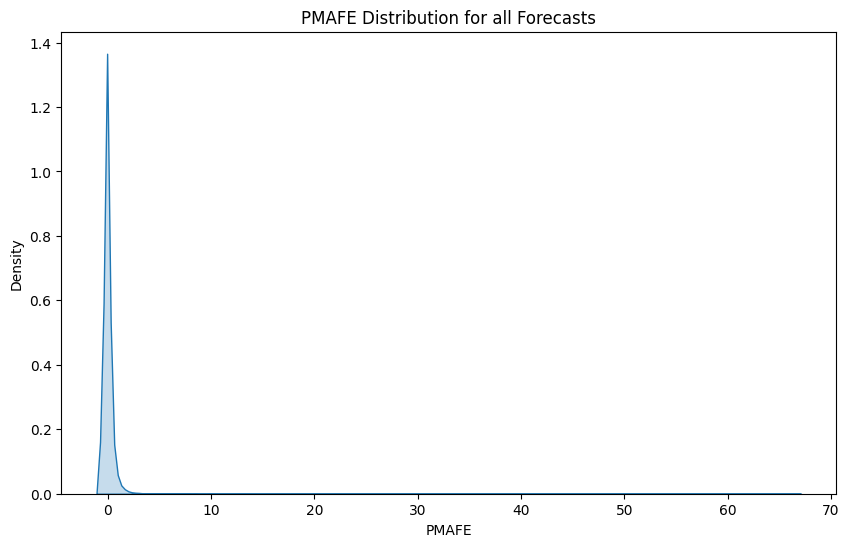

In [18]:
# density plot of PMAFE for all forecasts
plt.figure(figsize=(10, 6))
sns.kdeplot(df_forecasts['pmafe'], fill=True)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Density")
plt.show()

# Feature Engineering

## Feature 1: Broker Size

In [ ]:
def top_brokerage(df):
    """
    Function to add a dummy for each analyst that is employed by a firm in the top 50 brokerages in year t
    (Top 50: > 5.000 analysts)
    Set to 1 if analyst i is employed by a firm in the top 50 during year t (announce year), and set to 0 otherwise
    broker = df["estimator"]
    analyst = df["analyst"]
    broker_size = Count of analysts per brokerage in year t
    year = df["announce_date"].df.year 
    Output: this function adds a new column to the dataframe called "top_brokerage" with the dummy variable
    """
    # setup
    df["top_brokerage"] = 0
    df["broker_size"] = 0
    df["announce_date"] = pd.to_datetime(df["announce_date"])
    df["announce_year"] = df["announce_date"].dt.year
    
    # count of analysts per brokerage in year t
    df["broker_size"] = df.groupby(["estimator", "announce_year"])["analyst"].transform("count")
    
    # if count of analysts per brokerage in year t is greater than 5000, set top_brokerage to 1 otherwise 0
    df.loc[df["broker_size"] > 5000, "top_brokerage"] = 1
    
    
    return df

In [ ]:
df_forecasts = top_brokerage(df_forecasts)
df_forecasts.head()

## Feature 2:

# Collapse df

in the final df, one row should correspond to one analyst i's mean forecast of firm j in fiscal year t with accuracy measure pmafe

columns:
 - ibes_ticker_pk
 - company_name
 - gvkey
 - fiscal_period_ending
 - analyst
 - estimator
 - estimated_eps
 - mean_forecast_horizon
 - actual_eps
 - announce_date_actual
 - pmafe
 - afe_analyst_i_mean
 - afe_firm_j_mean
 - feature x
 - ...

In [34]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
0,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,173,0.17,0.198000,0.166786,0.187152,28
1,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,186,0.16,0.174286,0.166786,0.044968,28
2,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,181,0.13,0.158000,0.166786,-0.052677,28
3,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,186,0.13,0.174286,0.166786,0.044968,28
4,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,171,0.11,0.136667,0.166786,-0.180585,28


In [35]:
# test
analyst_id = 113333
test = df_forecasts[(df_forecasts['official_ticker'] == "AAPL") & (df_forecasts['fiscal_period_ending'].dt.year == 2018) & (df_forecasts['analyst'] == analyst_id)]
test

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
92567,AAPL,AAPL,APPLE,171,113333,2.900,2018-09-30,2018-01-29,2017-11-02,2.9775,2018-11-01,332 days,196,0.0775,0.06,0.130797,-0.541273,208
92630,AAPL,AAPL,APPLE,171,113333,2.935,2018-09-30,2018-04-30,2018-02-01,2.9775,2018-11-01,241 days,196,0.0425,0.06,0.130797,-0.541273,208
92697,AAPL,AAPL,APPLE,171,113333,2.885,2018-09-30,2018-07-30,2018-05-01,2.9775,2018-11-01,152 days,196,0.0925,0.06,0.130797,-0.541273,208
92739,AAPL,AAPL,APPLE,171,113333,2.950,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,0.0275,0.06,0.130797,-0.541273,208


In [36]:
# Group by 'ibes_ticker_pk', 'analyst', 'fiscal_period_ending' and find the row with the minimum 'forecast_horizon'
min_forecast = test.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'])['forecast_horizon'].idxmin()

# Extract rows with the minimum forecast horizon
min_forecast_df = test.loc[min_forecast]

In [37]:
min_forecast_df

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
92739,AAPL,AAPL,APPLE,171,113333,2.95,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,0.0275,0.06,0.130797,-0.541273,208


In [38]:
def collapse_processed_df(df):
    """_summary_
    This function collapses/groups the input df into the final df so that one row should correspond to one analyst 
    i's forecast of firm j in fiscal year t with accuracy measure pmafe and other relevant features
    """
    # Step 1: Group by 'ibes_ticker_pk', 'analyst', 'fiscal_period_ending' and find the row with the minimum 'forecast_horizon'
    min_forecast = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'])['forecast_horizon'].idxmin()
    min_forecast_df = df.loc[min_forecast]
    return min_forecast_df


In [39]:
collapsed_df = collapse_processed_df(df_forecasts)

In [40]:
# all unique tickets analyst 1133333 has forecasted in 2018
analyst_113333 = collapsed_df[collapsed_df['analyst'] == 113333]
analyst_113333['ibes_ticker_pk'].unique()

array(['AAPL', 'AMCV', 'AMER', 'CDLX', 'CDPD', 'CMCS', 'CRTO', 'CSTR',
       'DCHA', 'DCHA/2', 'DISH', 'FBK', 'GOOG', 'GOOG/1', 'GRUB', 'LCAP',
       'LOGI', 'LYFT', 'MVSN', 'NFLX', 'NWS', 'PPPP', 'RDFN', 'SNIW',
       'TIVO', 'TWCA', 'TWEE', 'VIA', 'VIAB', 'YELP', 'ZIL', 'ZIL/1'],
      dtype=object)

In [41]:
filtered_df = collapsed_df[(collapsed_df['analyst'] == analyst_id) & (collapsed_df['fiscal_period_ending'].dt.year == 2018) & ((collapsed_df['official_ticker'] == "NFLX") | (collapsed_df['official_ticker'] == "AAPL"))]
filtered_df

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
92739,AAPL,AAPL,APPLE,171,113333,2.95,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,0.0275,0.060,0.130797,-0.541273,208
881257,NFLX,NFLX,NETFLIX INC.,171,113333,2.62,2018-12-31,2019-01-15,2018-10-16,2.6800,2019-01-17,76 days,211,0.0600,0.285,0.150541,0.893166,205


# Export df

In [65]:
import os 
new_folder_path = '../data/processed' 

if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
file_path = os.path.join(new_folder_path, 'forecasts_pmafe_v2.parquet')
collapsed_df.to_parquet(file_path)

NameError: name 'collapsed_df' is not defined

In [60]:
crisp_cs_link = pd.read_csv('../data/raw/crisp-computsat-link.csv')
crisp_cs_link.to_parquet('../data/raw/crisp-computsat-link.parquet')

In [61]:
dataset2014 = pd.read_csv('../data/raw/dataset2014-2022-v3.csv')
dataset2014.to_parquet('../data/raw/dataset2014-2022-v3.parquet')

In [63]:
ibes_fc = pd.read_csv('../data/raw/ibes-forecasts.zip')
ibes_fc.to_parquet('../data/raw/ibes-forecasts.parquet')

In [64]:
old_data = pd.read_csv('../data/raw/1990-2014.zip')
old_data.to_parquet('../data/raw/1990-2014.parquet')

In [66]:
preproc = pd.read_pickle('../data/processed/forecasts_pmafe.pkl')
preproc.to_parquet('../data/processed/forecasts_pmafe.parquet')

In [67]:
link_crisp_ibes = pd.read_csv('../data/raw/link_table_crisp_ibes.csv')
link_crisp_ibes.to_parquet('../data/raw/link_table_crisp_ibes.parquet')